In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
!unzip gdrive/My\ Drive/test.zip
!unzip gdrive/My\ Drive/train.zip

In [0]:
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn import svm

# !pip install mglearn
# !pip install pyprind
import mglearn
import pyprind


import os,os.path
import string
import time
nltk.download('wordnet')
from bs4 import BeautifulSoup

from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

from sklearn.feature_selection import SelectKBest

import tensorflow as tf

porter = PorterStemmer()
count = CountVectorizer()
tfidf = TfidfTransformer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## General Processing

In [0]:
def processing(input_str):
  stop = set(stopwords.words('english'))
  
  
  input_str = BeautifulSoup(input_str).get_text()  
  # Remove characters that are not letters
  input_str1 = re.sub("[^a-zA-Z]", " ", input_str) 
  

  # Lowercase to string and split to words
  input_words = input_str1.lower().split()
  
  # Remove stopwords
  input_words1 = [words for words in input_words if words not in stop] 

  # lemmatization of words
  input_words1 = [WordNetLemmatizer().lemmatize(words) for words in input_words]
  
  # Convert to a string again
  output_str = ( " ".join(input_words1))
  
  return output_str

## Import Training Data

In [0]:
reviews_train = load_files("/content/train/")

text_train, y_train = reviews_train.data, reviews_train.target
y_train = np.array(y_train)
text_train = [doc.replace(b"<br />", b" ") for doc in text_train]  #remove html break
text_train = [doc.decode("utf-8") for doc in text_train]   #decode into utf8
text_train = np.array([processing(doc) for doc in text_train])    #perform general processing

# print("type of text_train: {}".format(type(text_train)))
# print("length of text_train: {}".format(len(text_train)))
# print("Samples per class (training): {}".format(np.bincount(y_train)))

In [0]:
# Common word removal
freq = pd.Series(' '.join(text_train).split()).value_counts()[:12]

freq = list(freq.index)
text_train = np.array(list(map(lambda x: " ".join(x for x in x.split() if x not in freq), text_train)))


In [0]:
# Rare words removal
freq = pd.Series(' '.join(text_train).split()).value_counts()[-100:]

freq = list(freq.index)
text_train = np.array(list(map(lambda x: " ".join(x for x in x.split() if x not in freq), text_train)))

In [0]:
# text_train

array(['zero day lead you think even re think why two boy young men would do what they did commit mutual suicide via slaughtering their classmate capture what must be beyond bizarre mode being for two human who have decided withdraw from common civility order define their own mutual world via coupled destruction not perfect movie but given what money time filmmaker actor had remarkable product term explaining motif action two young suicide murderer better than elephant term being film get under our rationalistic skin far far better film than almost anything you are likely see flawed but honest with terrible honesty',
       'word can t describe how bad movie can t explain by writing only you have too see for yourself get at grip how horrible movie really can be not recommend you do there are so many clich mistake all other negative thing you can imagine here will just make you cry start with technical first there are lot mistake regarding airplane won t list them here but just mention 

In [0]:
y_train

array([1, 0, 1, ..., 0, 0, 0])

## Pipeline 1: Raw Count

### Generate data matrix

In [0]:
# produce count vector and transform over the data into a feature matrix
vect = CountVectorizer(min_df = 5).fit(text_train)
X_train = vect.transform(text_train)
print("X_train:\n{}".format(repr(X_train)))


#print some feature names to check if you want
feature_names = vect.get_feature_names()
#print("Features 20010 to 20030:\n{}".format(feature_names[20010:20030]))


X_train:
<25000x24031 sparse matrix of type '<class 'numpy.int64'>'
	with 3270155 stored elements in Compressed Sparse Row format>


### 5-fold Cross validation & grid search for best C in logistic regression

In [0]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best cross-validation score: 0.88
Best parameters:  {'C': 0.1}


### Check data matrix

In [0]:
# transform the training dataset
X_train = vect.transform(text_train)
# find maximum value for each of the features over the dataset
max_value = X_train.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()
# get feature names
feature_names = np.array(vect.get_feature_names())
print("Features with lowest count:\n{}".format(
feature_names[sorted_by_tfidf[:20]]))
print("Features with highest count: \n{}".format(
feature_names[sorted_by_tfidf[-20:]]))

Features with lowest count:
['aa' 'racked' 'rack' 'existentialism' 'existentialist' 'racetrack'
 'exited' 'exiting' 'racket' 'exonerated' 'expand' 'expanded' 'expanding'
 'expands' 'expanse' 'expansion' 'expansive' 'raccoon' 'rabble' 'racking']
Features with highest count: 
['his' 'victor' 'like' 'wa' 'this' 'rob' 'her' 'you' 'titanic' 'it' 'but'
 'that' 'with' 'he' 'in' 'is' 'of' 'to' 'and' 'the']


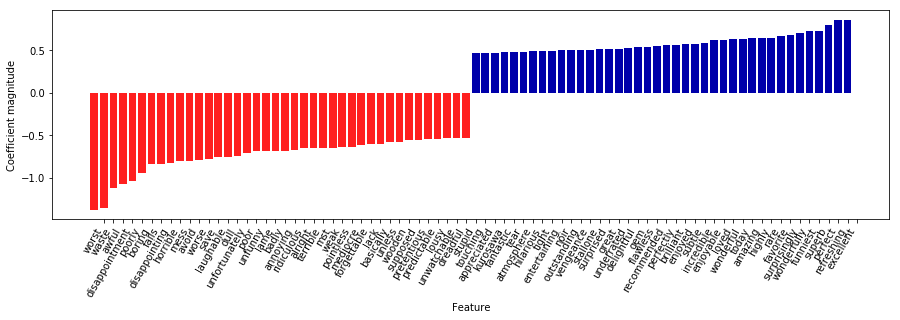

In [0]:
mglearn.tools.visualize_coefficients(
grid.best_estimator_.coef_,
feature_names, n_top_features=40)

## Pipeline 2: TF-IDF

### Generate data matrix

In [0]:
# produce count vector and transform over the data into a feature matrix
vect = TfidfVectorizer(min_df = 5).fit(text_train)
X_train = vect.transform(text_train)
print("X_train:\n{}".format(repr(X_train)))


#print some feature names to check if you want
feature_names = vect.get_feature_names()
#print("Features 20010 to 20030:\n{}".format(feature_names[20010:20030]))

X_train:
<25000x24031 sparse matrix of type '<class 'numpy.float64'>'
	with 3270155 stored elements in Compressed Sparse Row format>


### 5-fold Cross validation & grid search for best C in logistic regression

In [0]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best cross-validation score: 0.89
Best parameters:  {'C': 0.001}


### Check data matrix

In [0]:
# transform the training dataset
X_train = vect.transform(text_train)
# find maximum value for each of the features over the dataset
max_value = X_train.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()
# get feature names
feature_names = np.array(vect.get_feature_names())
print("Features with lowest tfidf:\n{}".format(
feature_names[sorted_by_tfidf[:20]]))
print("Features with highest tfidf: \n{}".format(
feature_names[sorted_by_tfidf[-20:]]))

Features with lowest tfidf:
['suplexes' 'gauche' 'oncoming' 'galadriel' 'songwriting' 'emerald'
 'gliding' 'mclaughlin' 'sylvain' 'pressuring' 'oversee' 'cataclysmic'
 'thieving' 'inconsiderate' 'denim' 'reverting' 'booed' 'spacious'
 'vertical' 'delegate']
Features with highest tfidf: 
['gadget' 'columbo' 'lennon' 'zatoichi' 'bye' 'dev' 'weller' 'sasquatch'
 'darkman' 'botched' 'xica' 'woo' 'casper' 'doodlebops' 'wei' 'smallville'
 'lv' 'steve' 'scanner' 'pokemon']


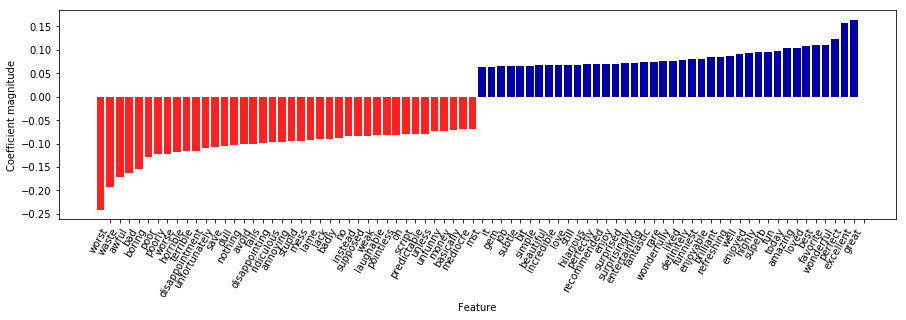

In [0]:
mglearn.tools.visualize_coefficients(
grid.best_estimator_.coef_,
feature_names, n_top_features=40)

## Pipeline 3: TF-IDF + Bi-gram

### Grid search for best n-gram and C in logistic regression

In [0]:
pipe = make_pipeline(TfidfVectorizer(min_df=5), LogisticRegression())
# running the grid search takes a long time because of the
# relatively large grid and the inclusion of trigrams
param_grid = {"logisticregression__C": [0.001, 0.01, 0.1, 1, 10, 100],
"tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)]}
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(text_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

Best cross-validation score: 0.91
Best parameters:
{'logisticregression__C': 100, 'tfidfvectorizer__ngram_range': (1, 3)}


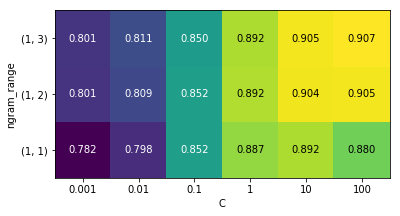

In [0]:
import matplotlib as plt
# extract scores from grid_search
scores = grid.cv_results_['mean_test_score'].reshape(-1, 3).T
# visualize heat map
heatmap = mglearn.tools.heatmap(
scores, xlabel="C", ylabel="ngram_range", cmap="viridis", fmt="%.3f",
xticklabels=param_grid['logisticregression__C'],
yticklabels=param_grid['tfidfvectorizer__ngram_range'])

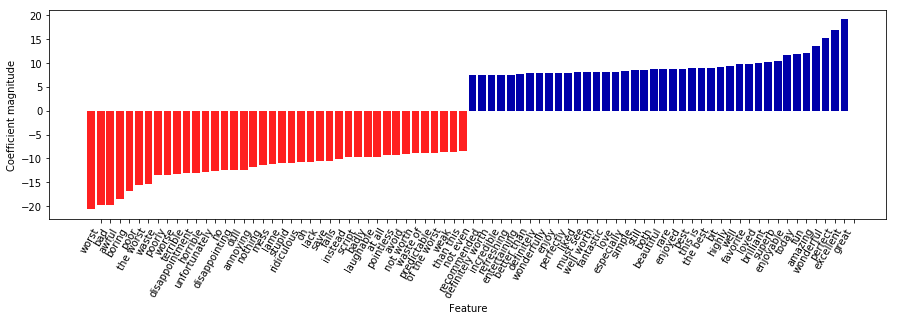

In [0]:
# extract feature names and coefficients
vect = grid.best_estimator_.named_steps['tfidfvectorizer']
feature_names = np.array(vect.get_feature_names())
coef = grid.best_estimator_.named_steps['logisticregression'].coef_
mglearn.tools.visualize_coefficients(coef, feature_names, n_top_features=40)

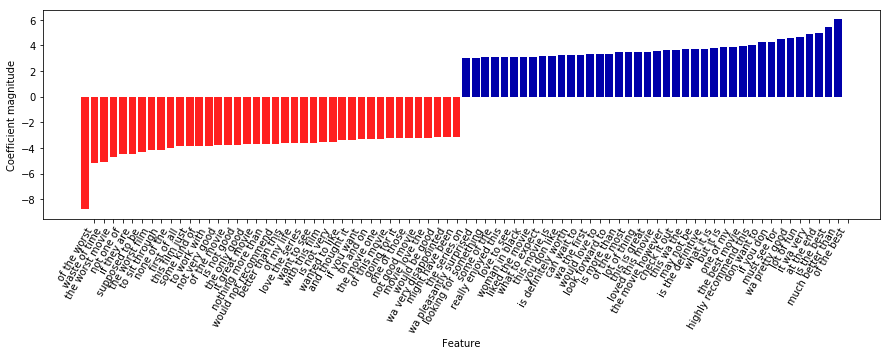

In [0]:
# find 3-gram features
mask = np.array([len(feature.split(" ")) for feature in feature_names]) == 3
# visualize only 3-gram features
mglearn.tools.visualize_coefficients(coef.ravel()[mask],
feature_names[mask], n_top_features=40)

# Best Logistic Regression Model

In [0]:


pipe = make_pipeline(TfidfVectorizer(ngram_range=(1,3),min_df=5), LogisticRegression())
# running the grid search takes a long time because of the
# relatively large grid and the inclusion of trigrams
param_grid = {
#     "logisticregression__C": [85, 95, 90],
# "tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)]}
#               "tfidfvectorizer__max_df": [8,9,10],
#               "tfidfvectorizer__min_df": [3,4,5]
              }
grid = GridSearchCV(pipe, param_grid,  scoring='accuracy',cv=5, verbose=10, n_jobs=-1)
grid.fit(text_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
# print("Best parameters:\n{}".format(grid.best_params_))

# Best Model
best_model = grid.best_estimator_

# Model Parameters
print("Best Model's Params: ", grid.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  3.3min remaining:  2.2min
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.7min finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Best cross-validation score: 0.89
Best Model's Params:  {}


# Try

In [0]:
tfidf = TfidfVectorizer(ngram_range=(1,3),min_df = 5)
X = tfidf.fit_transform(text_train)

In [0]:
from sklearn.model_selection import train_test_split
X_train_0, X_val_0, y_train_0, y_val_0 = train_test_split(X,y_train, test_size = 0.2, random_state = 0)

In [0]:
from sklearn.neural_network import MLPClassifier

mlp1 = MLPClassifier(alpha=0.01, hidden_layer_sizes=(10,10), activation='logistic',verbose=True)
mlp2 = MLPClassifier(alpha=0.01, hidden_layer_sizes=(10,10), activation='relu',verbose=True)  
mlp1.fit(X_train_0,y_train_0)
mlp2.fit(X_train_0,y_train_0)

In [0]:
y_pred1 = mlp1.predict(X_val_0)
y_pred2 = mlp2.predict(X_val_0)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_val_0,y_pred1))  
print(classification_report(y_val_0,y_pred1))  
print(accuracy_score(y_val_0, y_pred1)) 

print(confusion_matrix(y_val_0,y_pred2))  
print(classification_report(y_val_0,y_pred2))  
print(accuracy_score(y_val_0, y_pred2)) 

In [0]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC

# clf1 = LogisticRegression(C=100)
# clf2 = RandomForestClassifier(n_estimators=50)
# clf1 = GaussianNB()
clf1 = BernoulliNB()
clf2 = LinearSVC()

eclf1 = VotingClassifier(
        estimators=[('gnb', clf1), ('svc', clf2)], 
        voting='hard',
)

# eclf1 = eclf1.fit(X_train_0.toarray(), y_train_0)

pipe = make_pipeline(eclf1)
param_grid = {
    
              }
grid = GridSearchCV(pipe, param_grid,  scoring='accuracy',cv=5, verbose=10)

grid.fit(X_train_0.toarray(), y_train_0)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
# print("Best parameters:\n{}".format(grid.best_params_))

# Best Model
best_model = grid.best_estimator_

# Model Parameters
print("Best Model's Params: ", grid.best_params_)

# Best features selection

## Create features

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

max_num_features = 70000

tfidf = TfidfVectorizer(ngram_range=(1,3),min_df = 5)
X = tfidf.fit_transform(text_train)
y = np.array(y_train)
X_train_0, X_val_0, y_train_0, y_val_0 = train_test_split(X,y, test_size = 0.25, random_state = 0)

select = SelectFromModel(RandomForestClassifier(n_estimators=300, random_state=42),threshold="median",max_features=max_num_features)
select.fit(X_train_0,y_train_0)
X_train_l1 = select.transform(X_train_0)

print("X_train.shape: {}".format(X_train_0.shape))
print("X_train_l1.shape: {}".format(X_train_l1.shape))

X_val_l1 = select.transform(X_val_0)

# select = SelectFromModel(RandomForestClassifier(n_estimators=100),threshold="median")
# select.fit(X,y)

# X_train_l1 = select.transform(X_train_0)
# X_val_l1 = select.transform(X_val_0)

score = LogisticRegression(C=30).fit(X_train_l1,y_train_0).score(X_val_l1,y_val_0)
print("Validation score: {:.3f}".format(score))

X_train.shape: (18750, 246083)
X_train_l1.shape: (18750, 70000)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Validation score: 0.904


In [0]:
pipe = make_pipeline(LogisticRegression())

param_grid = {"logisticregression__C": [20, 30, 50]}
grid = GridSearchCV(pipe, param_grid, cv=10,verbose=10,scoring='accuracy',n_jobs=-1)
grid.fit(X_train_l1, y_train_0)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

# Best Model
best_model = grid.best_estimator_

# Model Parameters
print("Best Model's Params: ", grid.best_params_)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.8min finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Best cross-validation score: 0.90
Best parameters:
{'logisticregression__C': 30}


In [0]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
# clf.fit(X_train_l1, y_train_0)
clf.fit(X_train_0, y_train_0)

# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# clf = LinearDiscriminantAnalysis()
# clf.fit(X_train_l1.toarray(), y_train_0)

In [0]:
y_pred = clf.predict(X_val_l1)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_val_0,y_pred))  
print(classification_report(y_val_0,y_pred))  
print(accuracy_score(y_val_0, y_pred)) 

[[2159  270]
 [ 347 2224]]
              precision    recall  f1-score   support

           0       0.86      0.89      0.87      2429
           1       0.89      0.87      0.88      2571

   micro avg       0.88      0.88      0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000

0.8766


## Test features with logistic regression

In [0]:
pipe = make_pipeline(LogisticRegression(tol=0.00001,max_iter=1000,verbose=10, n_jobs=-1))
param_grid = {"logisticregression__C": [35]}
model = GridSearchCV(pipe, param_grid, scoring='accuracy',cv=5, verbose=10, n_jobs=-1)
model.fit(X_train_l1, y_train_0)
print("Best cross-validation score: {:.3f}".format(model.best_score_))
print("Best parameters:\n{}".format(model.best_params_))

best_model = model.best_estimator_
score = best_model.fit(X_train_l1,y_train_0).score(X_val_l1,y_val_0)

print("Validation score: {:.3f}".format(score))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   13.6s remaining:    9.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.4s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[LibLinear]Best cross-validation score: 0.903
Best parameters:
{'logisticregression__C': 35}
[LibLinear]Validation score: 0.903


# Additional Attempts

## Linear SVD

In [0]:
from sklearn.linear_model import SGDClassifier

# running the grid search takes a long time because of the
# relatively large grid and the inclusion of trigrams
pipe = make_pipeline(TfidfVectorizer(min_df=5), 
                     SGDClassifier(loss='hinge', penalty='l2',alpha=1e-5, tol=1e-3, learning_rate='optimal'))
param_grid = {"sgdclassifier__alpha": [1e-3, 1e-4, 1e-5],
"tfidfvectorizer__ngram_range": [(1, 2), (1, 3)]}
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(text_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

Best cross-validation score: 0.90
Best parameters:
{'sgdclassifier__alpha': 0.0001, 'tfidfvectorizer__ngram_range': (1, 3)}


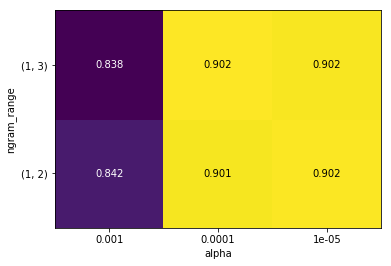

In [0]:
import matplotlib as plt
# extract scores from grid_search
scores = grid.cv_results_['mean_test_score'].reshape(-1, 2).T
# visualize heat map
heatmap = mglearn.tools.heatmap(
scores, xlabel="alpha", ylabel="ngram_range", cmap="viridis", fmt="%.3f",
xticklabels=param_grid['sgdclassifier__alpha'],
yticklabels=param_grid['tfidfvectorizer__ngram_range'])

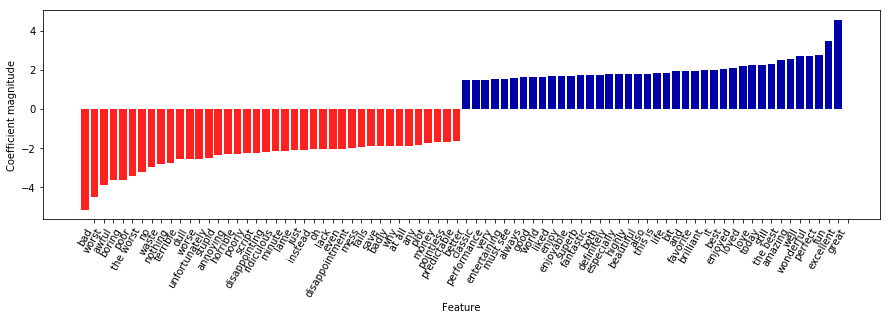

In [0]:
# extract feature names and coefficients
vect = grid.best_estimator_.named_steps['tfidfvectorizer']
feature_names = np.array(vect.get_feature_names())
coef = grid.best_estimator_.named_steps['sgdclassifier'].coef_
mglearn.tools.visualize_coefficients(coef, feature_names, n_top_features=40)

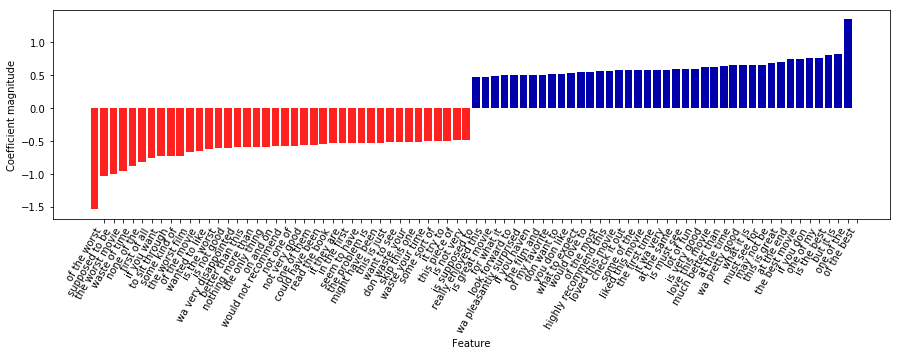

In [0]:
# find 3-gram features
mask = np.array([len(feature.split(" ")) for feature in feature_names]) == 3
# visualize only 3-gram features
mglearn.tools.visualize_coefficients(coef.ravel()[mask],
feature_names[mask], n_top_features=40)

## Word Embedding (Not sure what the vector means, ask TA at some point)

In [0]:
#Train a new word embedding model
import gensim
from nltk.tokenize import word_tokenize
from gensim.models import Phrases

#this is adapted to incorporat bigram
text_train_tokenized = [word_tokenize(doc) for doc in text_train]
bigram_transformer = Phrases(text_train_tokenized)

#train the model with vec size 100
model = gensim.models.Word2Vec(bigram_transformer[text_train_tokenized], size=100, min_count=10, window=5)
w2v = dict(zip(model.wv.index2word, model.wv.syn0))

In [0]:
#word embedding vectorizer with fit and transform methods
import collections

class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(word2vec.values())

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        max_idf = max(tfidf.idf_)
        self.word2weight = collections.defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [0]:
#data is prepared, feel free to try those on any model but I don't see improvement yet; maybe you will be the lucky one
vect = TfidfEmbeddingVectorizer(w2v).fit(text_train_tokenized,y_train)
X_train = vect.transform(text_train_tokenized)


## I dont suggest trying trees cuz it takes forever to train;
## this word embedding methods seems to work well with deep learning models as someone suggests


# Predictions and Generate Submission

In [0]:
import pandas as pd

def read_testfile(folder):
  df1 = pd.DataFrame()

    
  for file_num in range(0,25000):

    temp_name = folder+'/'+str(file_num)+'.txt'
    fileHandle = open (temp_name, encoding="utf8" )
    str2 = fileHandle.read()
      
    str2 = processing(str2)

    #file_name = re.sub("[^0-9]", "", file_name)
    
    df1 = df1.append([[file_num, str2]],ignore_index=True)
      
  df1.columns = ['Id', 'comment'] 
  df1 = df1.sort_values(by=['Id'])

  return df1


df_test = read_testfile('test/')
X_test = np.array(list(df_test['comment']))

In [0]:
#best model submitted so far, feel free to try your models in here; bi- or tri- gram does not make huge difference
pipe = make_pipeline(TfidfVectorizer(ngram_range=(1,3),min_df = 5), 
                     LogisticRegression(C= 100))

pipe.fit(text_train, y_train)

test_prediction = pipe.predict(X_test)

In [0]:
submission = pd.DataFrame({'Category': test_prediction, 
                           'Id': df_test['Id']})
cols = submission.columns.tolist()
cols = cols[-1:] + cols[:-1]
submission = submission[cols]
submission = submission.sort_values(by=['Id'])
submission.to_csv('submission.csv', index=False)

submission.head(100)

,Id,Category
0,0,0
1,1,0
2,2,0
3,3,0
4,4,1
5,5,0
6,6,0
7,7,0
8,8,0
9,9,0
